In [1]:
import pandas as pd
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.metrics import root_mean_squared_error

#

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///c:/Users/khanm375/Documents/mlops/02-experiment-tracking/mlruns/1', creation_time=1747094775418, experiment_id='1', last_update_time=1747094775418, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet(r'./data/green_tripdata_2021-01.parquet')


In [4]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

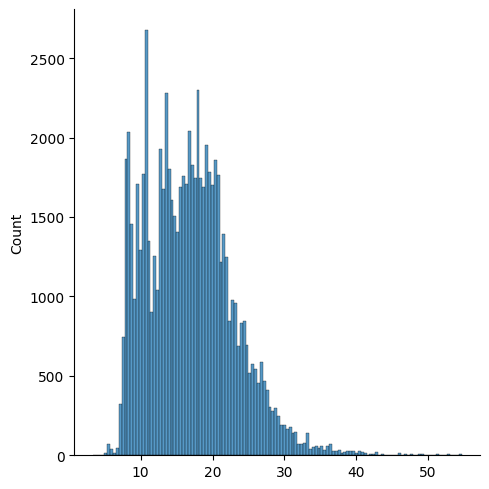

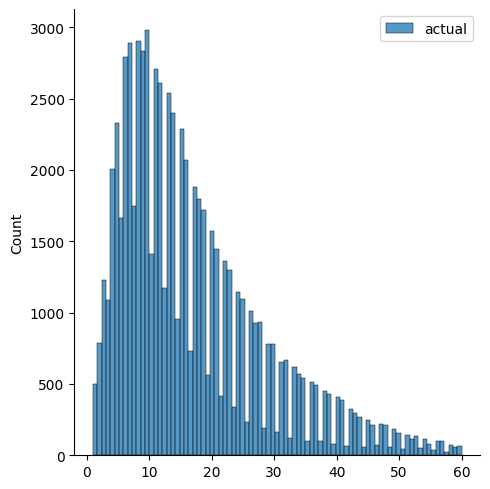

In [8]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:

len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715205596356

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "mustafa")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha=0.11
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

In [17]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from hyperopt.pyll import scope



In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.36483                          
[1]	validation-rmse:10.63128                          
[2]	validation-rmse:9.99860                           
[3]	validation-rmse:9.45676                           
[4]	validation-rmse:8.99335                           
[5]	validation-rmse:8.59936                           
[6]	validation-rmse:8.26471                           
[7]	validation-rmse:7.98336                           
[8]	validation-rmse:7.74772                           
[9]	validation-rmse:7.54948                           
[10]	validation-rmse:7.38320                          
[11]	validation-rmse:7.24389                          
[12]	validation-rmse:7.12725                          
[13]	validation-rmse:7.02972                          
[14]	validation-rmse:6.94683                          
[15]	validation-rmse:6.87589                          
[16]	validation-rmse:6.81921                          
[17]	validation-rmse:6.76892                          
[18]	valid

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:13:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80486                                                      
[1]	validation-rmse:7.48273                                                      
[2]	validation-rmse:7.00271                                                      
[3]	validation-rmse:6.82772                                                      
[4]	validation-rmse:6.73991                                                      
[5]	validation-rmse:6.70302                                                      
[6]	validation-rmse:6.68319                                                      
[7]	validation-rmse:6.66501                                                      
[8]	validation-rmse:6.65880                                                      
[9]	validation-rmse:6.65372                                                      
[10]	validation-rmse:6.64807                                                     
[11]	validation-rmse:6.64508                                                     
[12]	validation-

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.63996                                                    
[1]	validation-rmse:6.56275                                                    
[2]	validation-rmse:6.55685                                                    
[3]	validation-rmse:6.54652                                                    
[4]	validation-rmse:6.54279                                                    
[5]	validation-rmse:6.53388                                                    
[6]	validation-rmse:6.53124                                                    
[7]	validation-rmse:6.52529                                                    
[8]	validation-rmse:6.52002                                                    
[9]	validation-rmse:6.51592                                                    
[10]	validation-rmse:6.51173                                                   
[11]	validation-rmse:6.50783                                                   
[12]	validation-rmse:6.50399            

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:14:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78620                                                   
[1]	validation-rmse:11.38825                                                   
[2]	validation-rmse:11.01767                                                   
[3]	validation-rmse:10.67293                                                   
[4]	validation-rmse:10.35253                                                   
[5]	validation-rmse:10.05508                                                   
[6]	validation-rmse:9.77916                                                    
[7]	validation-rmse:9.52352                                                    
[8]	validation-rmse:9.28722                                                    
[9]	validation-rmse:9.06834                                                    
[10]	validation-rmse:8.86652                                                   
[11]	validation-rmse:8.68025                                                   
[12]	validation-rmse:8.50883            

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26846                                                     
[1]	validation-rmse:10.46671                                                     
[2]	validation-rmse:9.78941                                                      
[3]	validation-rmse:9.22135                                                      
[4]	validation-rmse:8.74591                                                      
[5]	validation-rmse:8.35049                                                      
[6]	validation-rmse:8.02408                                                      
[7]	validation-rmse:7.75709                                                      
[8]	validation-rmse:7.53735                                                      
[9]	validation-rmse:7.35539                                                      
[10]	validation-rmse:7.20695                                                     
[11]	validation-rmse:7.08538                                                     
[12]	validation-

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:18:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.03144                                                     
[1]	validation-rmse:10.08439                                                     
[2]	validation-rmse:9.33343                                                      
[3]	validation-rmse:8.74344                                                      
[4]	validation-rmse:8.28388                                                      
[5]	validation-rmse:7.92929                                                      
[6]	validation-rmse:7.65548                                                      
[7]	validation-rmse:7.44664                                                      
[8]	validation-rmse:7.28660                                                      
[9]	validation-rmse:7.16320                                                      
[10]	validation-rmse:7.06910                                                     
[11]	validation-rmse:6.99719                                                     
[12]	validation-

KeyboardInterrupt: 

In [20]:


with mlflow.start_run():
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1_000,
        evals=[(valid,'validaiton')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.bin", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    mlflow.log_artifact(local_path="models/preprocessor.bin", artifact_path="preprocessor")


c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validaiton-rmse:11.44482
[1]	validaiton-rmse:10.77202
[2]	validaiton-rmse:10.18363
[3]	validaiton-rmse:9.67396
[4]	validaiton-rmse:9.23166
[5]	validaiton-rmse:8.84808
[6]	validaiton-rmse:8.51883
[7]	validaiton-rmse:8.23597
[8]	validaiton-rmse:7.99320
[9]	validaiton-rmse:7.78709
[10]	validaiton-rmse:7.61022
[11]	validaiton-rmse:7.45952
[12]	validaiton-rmse:7.33049
[13]	validaiton-rmse:7.22098
[14]	validaiton-rmse:7.12713
[15]	validaiton-rmse:7.04752
[16]	validaiton-rmse:6.98005
[17]	validaiton-rmse:6.92232
[18]	validaiton-rmse:6.87112
[19]	validaiton-rmse:6.82740
[20]	validaiton-rmse:6.78995
[21]	validaiton-rmse:6.75792
[22]	validaiton-rmse:6.72994
[23]	validaiton-rmse:6.70547
[24]	validaiton-rmse:6.68390
[25]	validaiton-rmse:6.66421
[26]	validaiton-rmse:6.64806
[27]	validaiton-rmse:6.63280
[28]	validaiton-rmse:6.61924
[29]	validaiton-rmse:6.60773
[30]	validaiton-rmse:6.59777
[31]	validaiton-rmse:6.58875
[32]	validaiton-rmse:6.58107
[33]	validaiton-rmse:6.57217
[34]	validaiton-rmse:

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2025/05/13 21:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Load Model

In [21]:
import mlflow
logged_model = 'runs:/9c2617519a704176896dd5890e301896/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [24]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

c:\Users\khanm375\Documents\mlops\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [25]:
y_pred = xgboost_model.predict(valid)

In [26]:
y_pred[:10]

array([14.782765 ,  7.184751 , 15.971323 , 24.328938 ,  9.559302 ,
       17.115105 , 11.6522455,  8.688133 ,  8.962229 , 18.982166 ],
      dtype=float32)